# 2. Base de Dados da Aesa

```python
Esse caderno tem como objetivo a obtenção de precipitações acumuladas 
mensais para os dados locais.
```

In [1]:
import os
import numpy as np
import pandas as pd
import contextily as ctx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from geopy.distance import geodesic
from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

## 2.1. Configurações

In [2]:
# Definição de se vai gerar ou abrir o CSV
generate_csv_sum = False
generate_csv_max = False

# Definição de base de dados original
df_aesa = pd.read_csv('../datas/raw/2_aesa_data/aesa_1994-2023_day.csv')

# Redefinindo nomes das colunas

df_aesa = df_aesa.rename(
    columns={
        'Altitude': 'alt',
        'Bacia': 'bac',
        'Latitude': 'lat',
        'Longitude': 'lon',
        'Ano': 'ano',
        'Mês': 'mes',
    }
)

# Substituindo vírgulas por pontos e convertendo para float
for coluna in ['alt', 'lat', 'lon', 'Total']:
    df_aesa[coluna] = df_aesa[coluna].str.replace(',', '.').astype(float)

## 2.2. Funções

### 2.1.1. Função para Criar Serie Temporal Completa

In [3]:
def complete_temporal_series(df: pd.DataFrame,
                             lat_col: str,
                             lon_col: str,
                             alt_col: str,
                             bac_col: str,
                             anos: list) -> pd.DataFrame:
    '''
    Cria séries temporais com frequência mensal para localizações e anos definidos
    '''

    # Obtendo pontos de lat lon únicos
    df_pontos_unicos = df[[lat_col, lon_col, alt_col, bac_col]].drop_duplicates().reset_index().drop(columns=["index"])

    # Obtendo meses e anos da base de dados
    df_anos_meses = pd.DataFrame([(ano, mes) for ano in anos for mes in range(1, 13)], columns=["ano", "mes"])

    # Fazendo produto cartesiano entre pontos e anos/meses
    df_pontos_unicos['key'] = 1
    df_anos_meses['key'] = 1

    # Unindo pontos e anos/meses
    df_expandido = pd.merge(df_pontos_unicos, df_anos_meses, on='key').drop(columns='key')

    # Cria um DataFrame vazio para armazenar os dados expandidos
    return df_expandido

### 2.1.2. Função para Limeza de Terminal e Células

In [4]:
def clear():
    '''
    Função para limpar terminal ou célula
    '''

    # Limpando terminal
    # os.system('cls')

    # Limpando célula
    clear_output(wait=True)

### 2.1.3. Função para preencher nulos por Interpolação por IDW

In [5]:
def porcentagem_em_barra(valor_atual: int,
                         valor_total: int) -> str:
    """
    Gerador de barra de porcentagem a partir de valor atual e total.
    """

    porcentagem = 100 * (valor_atual / valor_total)

    completo   = '━' * (int(porcentagem))
    incompleto = '╺' * (100 - int(porcentagem))

    situacao = f'[{completo}{incompleto}] {porcentagem:.2f}% ({valor_atual} de {valor_total})'

    return situacao

def idw_interpolation(target_point, neighbors, values, const=2):
    """
    Interpolação IDW: valores dos vizinhos ponderados pela distância
    """

    weights = []
    for pt in neighbors:
        dist = geodesic(target_point, pt).meters
        if dist == 0:
            continue  # Evita usar o próprio ponto
        weights.append(1 / (dist ** const))
    weights = np.array(weights)
    values = np.array(values)
    return np.sum(weights * values) / np.sum(weights)

def preencher_precipitacao_idw(df: pd.DataFrame,
                               var_de_interpolacao: str,
                               var_de_latitude: str,
                               var_de_longitude: str,
                               var_de_anos: str,
                               var_de_meses: str,
                               n_vizinhos: int = 10,
                               const: int = 2) -> pd.DataFrame:

    df_resultado = df.copy()

    # Iterar sobre os índices com valores faltantes
    missing_indices = df_resultado[df_resultado[var_de_interpolacao].isna()].index

    valor_atual, valor_total = 1, len(missing_indices)

    for idx in missing_indices:

        row = df_resultado.loc[idx]
        ano, mes, lat, lon = row[var_de_anos], row[var_de_meses], row[var_de_latitude], row[var_de_longitude]
        target_point = (lat, lon)

        # Filtrar pontos com mesma data e precipitação conhecida
        filtro = (df_resultado[var_de_anos] == ano) & (df_resultado[var_de_meses] == mes) & df_resultado[var_de_interpolacao].notna()
        candidatos = df_resultado[filtro].copy()

        # Calcular distâncias
        candidatos['distancia'] = candidatos.apply(lambda r: geodesic(target_point, (r[var_de_latitude], r[var_de_longitude])).meters, axis=1)

        # Selecionar os pontos mais próximos
        vizinhos = candidatos.nsmallest(n_vizinhos, 'distancia')

        if not vizinhos.empty:
            viz_points = list(zip(vizinhos[var_de_latitude], vizinhos[var_de_longitude]))
            viz_values = vizinhos[var_de_interpolacao].tolist()

            # Aplicar IDW
            interpolado = idw_interpolation(target_point, viz_points, viz_values, const)
            df_resultado.at[idx, var_de_interpolacao] = interpolado

        if valor_atual % 10 == 0 or valor_atual == valor_total:
            clear()
            print(porcentagem_em_barra(valor_atual, valor_total))

        valor_atual += 1

    return df_resultado

### 2.1.4. Função para gerar gráfico de pontos para Paraíba

In [6]:
def grafico_de_pontos(df: pd.DataFrame,
                      latitude: str,
                      longitude: str):
    '''
    Função gera gráfico de pontos para região da Paraíba a partir de DataFrame
    '''

    # Exemplo de dados de precipitação
    latitudes = df[latitude].values
    longitudes = df[longitude].values

    # Criar o gráfico com Cartopy
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.Mercator()})
    ax.set_extent([-38.8, -34.7, -8.3, -6], crs=ccrs.PlateCarree())  # Definir a extensão de latitude e longitude

    # Adicionar o mapa base
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    # Desenhar as bordas do mapa
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linestyle='-', linewidth=0.5)

    # Desenhar paralelos e meridianos, ajustando a frequência dos labels
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
    gridlines.xlocator = MaxNLocator(integer=True, prune='lower', nbins=4)  # Limitar o número de labels para longitude
    gridlines.ylocator = MaxNLocator(integer=True, prune='lower', nbins=4)  # Limitar o número de labels para latitude

    # Criar o scatter plot com pontos azuis
    ax.scatter(longitudes, latitudes, color='blue', s=3, marker='o', transform=ccrs.PlateCarree())

    # Adicionar título e rótulos
    plt.title('Estado da Paraíba')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Mostrar o mapa
    plt.show()

## 2.3. Geração de base de dados

### 2.3.1. Precipitações mensais acumuladas

In [7]:
# Salvando ou abrindo base de dados
if generate_csv_sum == True:

    # Configurando colunas da base de dados a partir de base de dados original
    df_aesa_sum = df_aesa[['alt', 'bac', 'lat', 'lon', 'ano', 'mes', 'Total']].rename(
        columns={
            'Total': 'pr_local'
        }
    )

    # Obtendo base de dados com serie temporal completa
    df_expandido = complete_temporal_series(df_aesa, 'lat', 'lon', 'alt', 'bac', [i for i in range(1994, 2024)])

    # Faz o merge com df_expandido como base
    df_aesa_sum = pd.merge(
        df_expandido,
        df_aesa_sum,
        on=['lat', 'lon', 'alt', 'bac', 'ano', 'mes'],
        how='left'
    )

    # Interpolando linhas nulas de altura
    # df_aesa_sum = preencher_precipitacao_idw(df_aesa_sum, 'alt', 'alt', 'lat', 'lon', 'ano', 'mes', 'pnt', 5)

    # Interpolando linhas nulas de precipitação
    df_aesa_sum = preencher_precipitacao_idw(df_aesa_sum, 'pr_local', 'lat', 'lon', 'ano', 'mes', 10)  # 4m 23.4s | 32 lin/seg

    # Salva CSV
    df_aesa_sum[['lat', 'lon',
                 'ano', 'mes', 'pr_local'
    ]].to_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_sum.csv")

else:

    # Abre CSV
    df_aesa_sum = pd.read_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_sum.csv")

# Informações da base de dados
df_aesa_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87120 entries, 0 to 87119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  87120 non-null  int64  
 1   lat         87120 non-null  float64
 2   lon         87120 non-null  float64
 3   ano         87120 non-null  int64  
 4   mes         87120 non-null  int64  
 5   pr_local    87120 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 4.0 MB


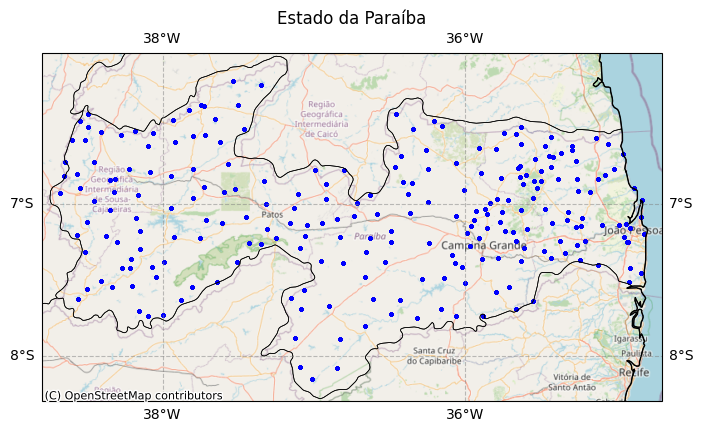

In [8]:
grafico_de_pontos(df_aesa_sum, 'lat', 'lon')

### 2.2.2. Geração de base de dados de precipitações diárias mensais máximas

```Python
# Salvando ou abrindo base de dados
if generate_csv_max == True:

    # Definindo base de dados
    df_aesa_max = df_aesa.copy()

    # Definindo colunas de interesse
    colunas = [f'dia {i}' for i in range(1, 31)]

    # Converter as colunas para float
    for coluna in colunas:
        df_aesa_max[coluna] = pd.to_numeric(df_aesa_max[coluna].str.replace(',', '.').str.strip(), errors='coerce')

    # Criar a coluna com o maior valor por linha
    df_aesa_max['Máximo'] = df_aesa_max[colunas].max(axis=1)

    # Configurando colunas da base de dados a partir de base de dados original
    df_aesa_max = df_aesa_max[['alt', 'bac', 'lat', 'lon', 'ano', 'mes', 'Máximo']].rename(
        columns={
            'Máximo': 'pr_local'
        }
    )

    # Obtendo base de dados com serie temporal completa
    df_expandido = complete_temporal_series(df_aesa, 'lat', 'lon', 'alt', 'bac', [i for i in range(1994, 2024)])

    # Faz o merge com df_expandido como base
    df_aesa_max = pd.merge(
        df_expandido,
        df_aesa_max,
        on=['lat', 'lon', 'alt', 'bac', 'ano', 'mes'],
        how='left'
    )


    # Interpolando linhas nulas
    df_aesa_max = interpolacao_por_idw(df_aesa_max, 'alt', 'lat', 'lon', 'ano', 'mes')
    
    # Interpolando linhas nulas de precipitação
    df_aesa_max = interpolacao_por_idw(df_aesa_max, 'pr_local', 'lat', 'lon', 'ano', 'mes')

    # Salva CSV
    df_aesa_max.to_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_max.csv")
    
else:
    
    # Abre CSV
    df_aesa_max = pd.read_csv("../datas/interim/2.3.1_aesa_database_create/aesa_1994-2023_mon_max.csv") 

# Informações da base de dados
df_aesa_max.info()

grafico_de_pontos(df_aesa_max, 'lat', 'lon')
```